---
## 1. Setup & Data Loading

In [47]:
# Core libraries
import pandas as pd
import numpy as np
import json
from pathlib import Path

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

# Statistics
from scipy import stats
from scipy.stats import f_oneway

# Configuration
RANDOM_STATE = 67
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

print("Libraries loaded successfully")

Libraries loaded successfully


In [48]:
# Load data
DATA_PATH = Path('data/AIRS_clean.csv')
df = pd.read_csv(DATA_PATH)
print(f"Dataset loaded: {df.shape[0]} rows × {df.shape[1]} columns")

# Define construct items
AIRS16_CONSTRUCTS = ['PE', 'EE', 'SI', 'FC', 'HM', 'PV', 'HB', 'TR']
OUTCOME = 'BI'

# Compute construct scores
for c in AIRS16_CONSTRUCTS:
    df[c] = df[[f'{c}1', f'{c}2']].mean(axis=1)
df['BI'] = df[['BI1', 'BI2', 'BI3', 'BI4']].mean(axis=1)

print(f"\nConstruct scores computed: {AIRS16_CONSTRUCTS}")

Dataset loaded: 523 rows × 41 columns

Construct scores computed: ['PE', 'EE', 'SI', 'FC', 'HM', 'PV', 'HB', 'TR']


In [49]:
# Load Notebook 11 results (ground truth clustering)
NB11_PATH = Path('results/phase11_practitioner_typology_results.json')

if NB11_PATH.exists():
    with open(NB11_PATH, 'r') as f:
        nb11_results = json.load(f)
    print("Notebook 11 results loaded successfully")
    print(f"  Clusters: {nb11_results['clustering']['n_clusters']}")
    print(f"  Silhouette: {nb11_results['clustering']['silhouette_score']:.3f}")
    print(f"  BI η²: {nb11_results['validation']['bi_eta_squared']:.3f}")
else:
    print("WARNING: NB11 results not found. Run Notebook 11 first.")
    nb11_results = None

Notebook 11 results loaded successfully
  Clusters: 3
  Silhouette: 0.271
  BI η²: 0.659


In [50]:
# Recreate NB11 clustering for comparison (ground truth)
from sklearn.cluster import KMeans

X = df[AIRS16_CONSTRUCTS].copy()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=3, random_state=RANDOM_STATE, n_init=10)
df['Cluster_NB11'] = kmeans.fit_predict(X_scaled)

# Map to names (from NB11)
CLUSTER_NAMES = {0: 'Moderate Users', 1: 'AI Skeptics', 2: 'AI Enthusiasts'}
df['Typology_NB11'] = df['Cluster_NB11'].map(CLUSTER_NAMES)

print("Ground Truth Clustering (NB11):")
print(df['Typology_NB11'].value_counts())

Ground Truth Clustering (NB11):
Typology_NB11
Moderate Users    246
AI Enthusiasts    162
AI Skeptics       115
Name: count, dtype: int64


---
## 2. Method 1: Composite Score + Cut-Points

**Approach**: Create a single "AI Readiness Index" by summing all 8 constructs, then use percentile-based cut-points.

### 2.1 Create AI Readiness Index

In [51]:
# Method 1a: Simple sum (unweighted)
df['ARI_Sum'] = df[AIRS16_CONSTRUCTS].sum(axis=1)

# Method 1b: Weighted sum (using regression coefficients from NB11)
# First, get regression weights
reg = LinearRegression()
reg.fit(df[AIRS16_CONSTRUCTS], df['BI'])

# Standardized weights
X_std = (df[AIRS16_CONSTRUCTS] - df[AIRS16_CONSTRUCTS].mean()) / df[AIRS16_CONSTRUCTS].std()
reg_std = LinearRegression()
reg_std.fit(X_std, df['BI'])

weights = pd.Series(reg_std.coef_, index=AIRS16_CONSTRUCTS)
print("Regression Weights (standardized β):")
print(weights.sort_values(ascending=False).round(3))

# Weighted index (using only positive weights for interpretability)
pos_weights = weights.clip(lower=0)
pos_weights = pos_weights / pos_weights.sum()  # Normalize to sum to 1
df['ARI_Weighted'] = (df[AIRS16_CONSTRUCTS] * pos_weights).sum(axis=1)

Regression Weights (standardized β):
PV    0.316
HM    0.286
TR    0.169
SI    0.138
PE    0.093
HB    0.063
FC    0.060
EE    0.013
dtype: float64


In [52]:
# Descriptive statistics for indices
print("AI Readiness Index Statistics:")
print("=" * 50)

for idx_name in ['ARI_Sum', 'ARI_Weighted']:
    print(f"\n{idx_name}:")
    print(f"  Range: {df[idx_name].min():.2f} - {df[idx_name].max():.2f}")
    print(f"  Mean: {df[idx_name].mean():.2f} (SD = {df[idx_name].std():.2f})")
    print(f"  Correlation with BI: r = {df[idx_name].corr(df['BI']):.3f}")

AI Readiness Index Statistics:

ARI_Sum:
  Range: 8.00 - 40.00
  Mean: 26.62 (SD = 7.28)
  Correlation with BI: r = 0.876

ARI_Weighted:
  Range: 1.00 - 5.00
  Mean: 3.32 (SD = 0.97)
  Correlation with BI: r = 0.891


Correlation: AI Readiness Index (ARI) vs Behavioral Intention (BI)
ARI = Sum of 8 construct means (range: 8-40)

Pearson r = 0.876
R² = 0.768 (76.8% variance explained)

Interpretation: Strong positive correlation


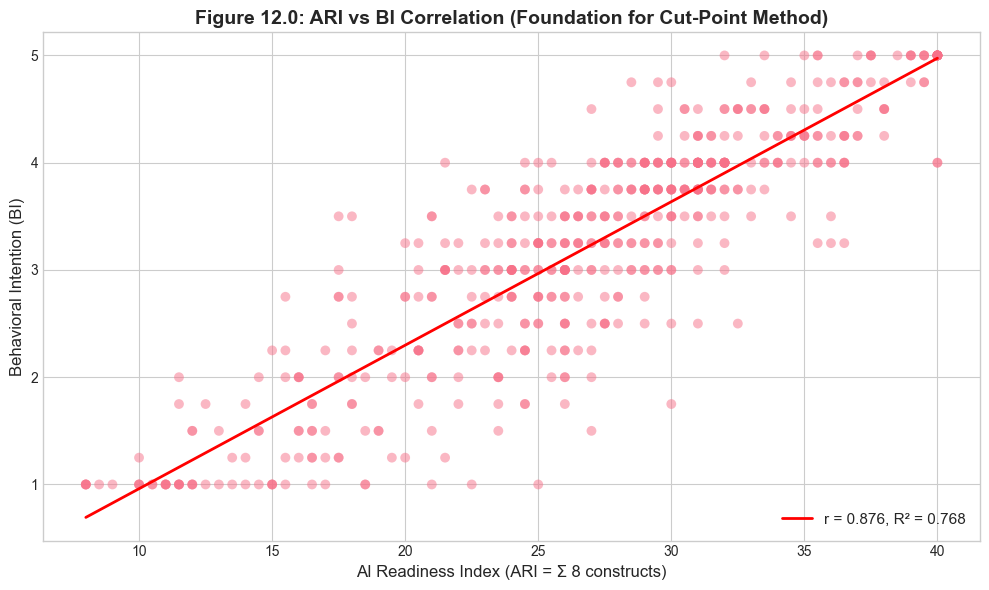


→ This strong correlation (r = 0.876) justifies using ARI sum for classification


In [53]:
# Correlation analysis: ARI vs BI (from NB11)
r_ari_bi = df['ARI_Sum'].corr(df['BI'])
r_squared = r_ari_bi ** 2

print("Correlation: AI Readiness Index (ARI) vs Behavioral Intention (BI)")
print("=" * 60)
print(f"ARI = Sum of {len(AIRS16_CONSTRUCTS)} construct means (range: 8-40)")
print(f"\nPearson r = {r_ari_bi:.3f}")
print(f"R² = {r_squared:.3f} ({r_squared*100:.1f}% variance explained)")
print(f"\nInterpretation: {'Strong' if abs(r_ari_bi) >= 0.7 else 'Moderate' if abs(r_ari_bi) >= 0.4 else 'Weak'} positive correlation")

# Figure 12.0: Scatter plot ARI vs BI
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(df['ARI_Sum'], df['BI'], alpha=0.5, edgecolors='none', s=50)

# Add regression line
z = np.polyfit(df['ARI_Sum'], df['BI'], 1)
p = np.poly1d(z)
x_line = np.linspace(df['ARI_Sum'].min(), df['ARI_Sum'].max(), 100)
ax.plot(x_line, p(x_line), 'r-', linewidth=2, label=f'r = {r_ari_bi:.3f}, R² = {r_squared:.3f}')

ax.set_xlabel('AI Readiness Index (ARI = Σ 8 constructs)', fontsize=12)
ax.set_ylabel('Behavioral Intention (BI)', fontsize=12)
ax.set_title('Figure 12.0: ARI vs BI Correlation (Foundation for Cut-Point Method)', fontsize=14, fontweight='bold')
ax.legend(loc='lower right', fontsize=11)

plt.tight_layout()
plt.savefig('plots/12_00_ari_bi_correlation.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n→ This strong correlation (r = {r_ari_bi:.3f}) justifies using ARI sum for classification")

### 2.2 Establish Cut-Points

In [54]:
# Method 1: Tertile-based cut-points (33rd and 67th percentiles)
p33 = df['ARI_Sum'].quantile(0.33)
p67 = df['ARI_Sum'].quantile(0.67)

print("Tertile Cut-Points (ARI_Sum):")
print(f"  Low (AI Skeptics): < {p33:.2f}")
print(f"  Medium (Moderate Users): {p33:.2f} - {p67:.2f}")
print(f"  High (AI Enthusiasts): > {p67:.2f}")

Tertile Cut-Points (ARI_Sum):
  Low (AI Skeptics): < 24.50
  Medium (Moderate Users): 24.50 - 30.00
  High (AI Enthusiasts): > 30.00


In [55]:
# Method 2: Optimize cut-points to match NB11 clustering
from scipy.optimize import minimize

def classify_by_cutpoints(ari, low_cut, high_cut):
    """Classify using two cut-points."""
    if ari < low_cut:
        return 'AI Skeptics'
    elif ari > high_cut:
        return 'AI Enthusiasts'
    else:
        return 'Moderate Users'

def objective(cuts, ari_values, true_labels):
    """Minimize misclassification rate."""
    low_cut, high_cut = cuts
    if low_cut >= high_cut:
        return 1.0  # Invalid
    pred = [classify_by_cutpoints(x, low_cut, high_cut) for x in ari_values]
    return 1 - accuracy_score(true_labels, pred)

# Optimize
result = minimize(
    objective,
    x0=[p33, p67],  # Start with tertiles
    args=(df['ARI_Sum'].values, df['Typology_NB11'].values),
    method='Nelder-Mead'
)

opt_low, opt_high = result.x
print(f"\nOptimized Cut-Points:")
print(f"  Low threshold: {opt_low:.2f}")
print(f"  High threshold: {opt_high:.2f}")


Optimized Cut-Points:
  Low threshold: 21.13
  High threshold: 30.75


In [56]:
# Apply practical cut-points (20, 30) for field use
PRACTICAL_LOW = 20
PRACTICAL_HIGH = 30

df['Typology_CutPoint'] = df['ARI_Sum'].apply(
    lambda x: classify_by_cutpoints(x, PRACTICAL_LOW, PRACTICAL_HIGH)
)

# Evaluate accuracy
acc_cutpoint = accuracy_score(df['Typology_NB11'], df['Typology_CutPoint'])
print(f"\\nCut-Point Classification Results (Practical 20/30):")
print(f"  Low threshold: {PRACTICAL_LOW}")
print(f"  High threshold: {PRACTICAL_HIGH}")
print(f"  Accuracy vs NB11: {acc_cutpoint*100:.1f}%")
print(f"\\nDistribution:")
print(df['Typology_CutPoint'].value_counts())

\nCut-Point Classification Results (Practical 20/30):
  Low threshold: 20
  High threshold: 30
  Accuracy vs NB11: 94.5%
\nDistribution:
Typology_CutPoint
Moderate Users    263
AI Enthusiasts    168
AI Skeptics        92
Name: count, dtype: int64


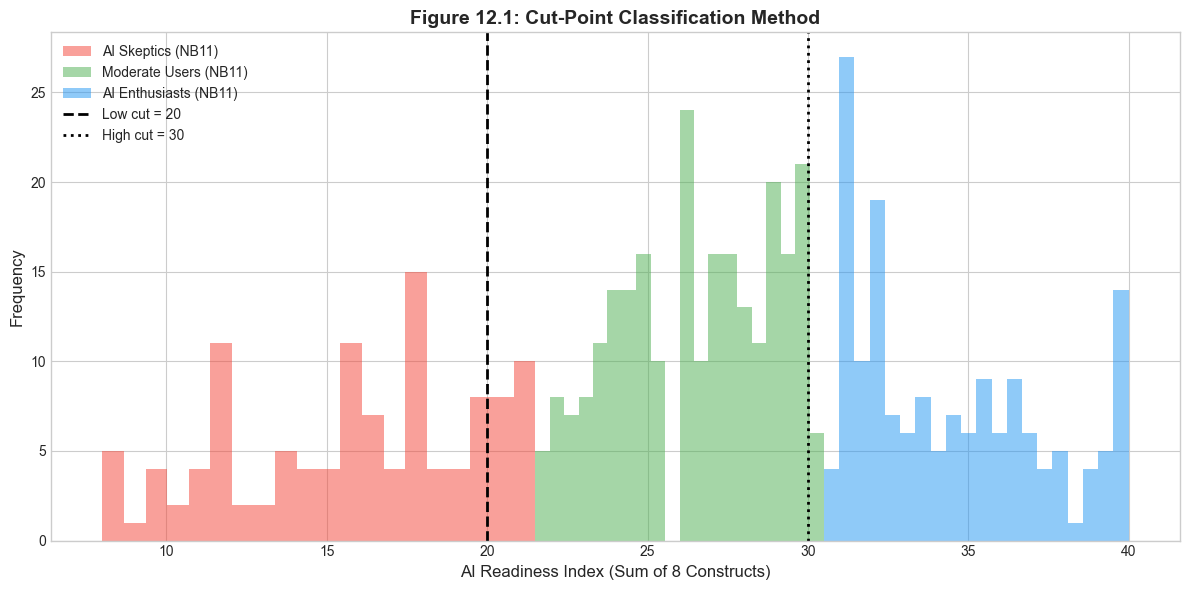

In [57]:
# Figure 12.1: Cut-Point Visualization (Practical 20/30 thresholds)
fig, ax = plt.subplots(figsize=(12, 6))

# Histogram with cut-points
colors = {'AI Skeptics': '#F44336', 'Moderate Users': '#4CAF50', 'AI Enthusiasts': '#2196F3'}
for typology in ['AI Skeptics', 'Moderate Users', 'AI Enthusiasts']:
    mask = df['Typology_NB11'] == typology
    ax.hist(df.loc[mask, 'ARI_Sum'], bins=20, alpha=0.5, 
            label=f'{typology} (NB11)', color=colors[typology])

ax.axvline(x=PRACTICAL_LOW, color='black', linestyle='--', linewidth=2, label=f'Low cut = {PRACTICAL_LOW}')
ax.axvline(x=PRACTICAL_HIGH, color='black', linestyle=':', linewidth=2, label=f'High cut = {PRACTICAL_HIGH}')

ax.set_xlabel('AI Readiness Index (Sum of 8 Constructs)', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.set_title('Figure 12.1: Cut-Point Classification Method', fontsize=14, fontweight='bold')
ax.legend(loc='upper left')

plt.tight_layout()
plt.savefig('plots/12_01_cutpoint_classification.png', dpi=150, bbox_inches='tight')
plt.show()

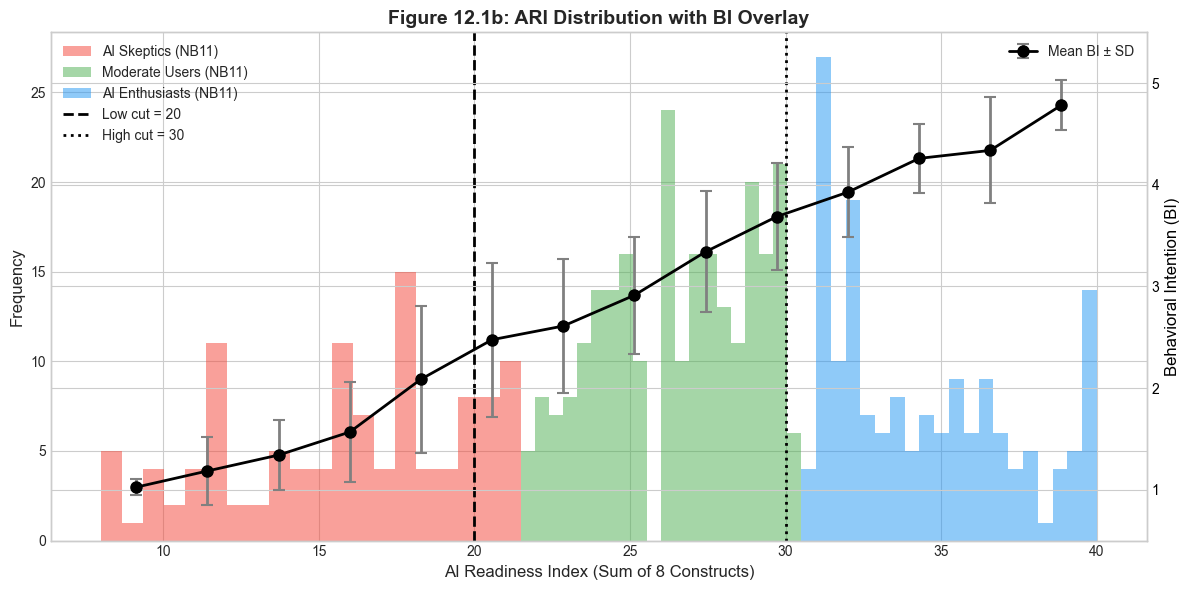

In [58]:
# Figure 12.1b: Cut-Point Visualization with BI Overlay (Practical 20/30 thresholds)
fig, ax1 = plt.subplots(figsize=(12, 6))

# Histogram with cut-points (left y-axis)
colors = {'AI Skeptics': '#F44336', 'Moderate Users': '#4CAF50', 'AI Enthusiasts': '#2196F3'}
for typology in ['AI Skeptics', 'Moderate Users', 'AI Enthusiasts']:
    mask = df['Typology_NB11'] == typology
    ax1.hist(df.loc[mask, 'ARI_Sum'], bins=20, alpha=0.5, 
            label=f'{typology} (NB11)', color=colors[typology])

ax1.axvline(x=PRACTICAL_LOW, color='black', linestyle='--', linewidth=2, label=f'Low cut = {PRACTICAL_LOW}')
ax1.axvline(x=PRACTICAL_HIGH, color='black', linestyle=':', linewidth=2, label=f'High cut = {PRACTICAL_HIGH}')

ax1.set_xlabel('AI Readiness Index (Sum of 8 Constructs)', fontsize=12)
ax1.set_ylabel('Frequency', fontsize=12)
ax1.legend(loc='upper left')

# Create second y-axis for BI
ax2 = ax1.twinx()

# Calculate mean BI and standard deviation for each ARI bin
ari_bins = np.linspace(df['ARI_Sum'].min(), df['ARI_Sum'].max(), 15)
ari_centers = (ari_bins[:-1] + ari_bins[1:]) / 2
bi_means_by_ari = []
bi_stds_by_ari = []

for i in range(len(ari_bins) - 1):
    mask = (df['ARI_Sum'] >= ari_bins[i]) & (df['ARI_Sum'] < ari_bins[i+1])
    if mask.sum() > 0:
        bi_means_by_ari.append(df.loc[mask, 'BI'].mean())
        bi_stds_by_ari.append(df.loc[mask, 'BI'].std())
    else:
        bi_means_by_ari.append(np.nan)
        bi_stds_by_ari.append(np.nan)

# Convert to arrays for plotting
bi_means_by_ari = np.array(bi_means_by_ari)
bi_stds_by_ari = np.array(bi_stds_by_ari)

# Plot BI line with error bars on second axis
ax2.errorbar(ari_centers, bi_means_by_ari, yerr=bi_stds_by_ari, 
             fmt='ko-', linewidth=2, markersize=8, capsize=4, capthick=1.5,
             ecolor='gray', label='Mean BI ± SD')
ax2.set_ylabel('Behavioral Intention (BI)', fontsize=12, color='black')
ax2.tick_params(axis='y', labelcolor='black')
ax2.set_ylim(0.5, 5.5)  # Expanded to accommodate error bars
ax2.legend(loc='upper right')

ax1.set_title('Figure 12.1b: ARI Distribution with BI Overlay', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('plots/12_01b_cutpoint_with_bi.png', dpi=150, bbox_inches='tight')
plt.show()

In [59]:
# Validation: Practical Cut-Point Method (20/30) Performance
print("=" * 60)
print("PRACTICAL CUT-POINT METHOD VALIDATION")
print("=" * 60)

print(f"\nThresholds: ARI ≤ 20 → AI Skeptics")
print(f"            ARI 21-30 → Moderate Users")
print(f"            ARI > 30 → AI Enthusiasts")

# Confusion matrix
print("\n" + "-" * 40)
print("Confusion Matrix (Cut-Point vs NB11 K-Means)")
print("-" * 40)
ct_cutpoint = pd.crosstab(df['Typology_NB11'], df['Typology_CutPoint'], 
                          margins=True, margins_name='Total')
print(ct_cutpoint)

# Accuracy metrics
misclass_count = (df['Typology_CutPoint'] != df['Typology_NB11']).sum()
print(f"\nAccuracy: {acc_cutpoint:.1%} ({misclass_count} misclassifications out of {len(df)})")

# Show misclassified cases
print("\n" + "-" * 40)
print("Misclassified Cases (boundary cases)")
print("-" * 40)
misclassified = df[df['Typology_CutPoint'] != df['Typology_NB11']][
    ['ARI_Sum', 'BI', 'Typology_NB11', 'Typology_CutPoint']
].sort_values('ARI_Sum')
if len(misclassified) > 0:
    print(misclassified.to_string())
else:
    print("No misclassifications!")

# Effect size
groups_cutpoint = [df.loc[df['Typology_CutPoint'] == t, 'BI'].values 
                   for t in ['AI Skeptics', 'Moderate Users', 'AI Enthusiasts']]
ss_between_cutpoint = sum(len(g) * (g.mean() - grand_mean)**2 for g in groups_cutpoint)
eta_sq_cutpoint = ss_between_cutpoint / ss_total

print("\n" + "-" * 40)
print("Effect Size (η² for Behavioral Intention)")
print("-" * 40)
print(f"  Practical Cut-Point (20/30): η² = {eta_sq_cutpoint:.3f}")
print(f"  NB11 K-Means Reference:      η² = {nb11_eta:.3f}")

print("\n" + "=" * 60)
print("CONCLUSION")
print("=" * 60)
print(f"The practical 20/30 cut-points achieve:")
print(f"  • {acc_cutpoint:.1%} accuracy vs multivariate clustering")
print(f"  • η² = {eta_sq_cutpoint:.3f} (large effect size)")
print(f"  • Simple scoring: Sum 8 constructs, apply thresholds")
print(f"\n✓ Suitable for practitioner self-assessment and field use")

PRACTICAL CUT-POINT METHOD VALIDATION

Thresholds: ARI ≤ 20 → AI Skeptics
            ARI 21-30 → Moderate Users
            ARI > 30 → AI Enthusiasts

----------------------------------------
Confusion Matrix (Cut-Point vs NB11 K-Means)
----------------------------------------
Typology_CutPoint  AI Enthusiasts  AI Skeptics  Moderate Users  Total
Typology_NB11                                                        
AI Enthusiasts                162            0               0    162
AI Skeptics                     0           92              23    115
Moderate Users                  6            0             240    246
Total                         168           92             263    523

Accuracy: 94.5% (29 misclassifications out of 523)

----------------------------------------
Misclassified Cases (boundary cases)
----------------------------------------
     ARI_Sum    BI   Typology_NB11 Typology_CutPoint
8       20.0  2.00     AI Skeptics    Moderate Users
17      20.0  3.25     

### 2.3 BI Prediction with Cut-Point Method

In [60]:
# Calculate BI means by cut-point typology
bi_by_cutpoint = df.groupby('Typology_CutPoint')['BI'].agg(['mean', 'std', 'count'])
bi_by_cutpoint.columns = ['Mean BI', 'SD', 'n']

print("Table 12.1: BI by Cut-Point Typology")
print("=" * 50)
display(bi_by_cutpoint.round(3))

# Calculate eta-squared for cut-point method
groups = [df[df['Typology_CutPoint'] == t]['BI'].values for t in ['AI Skeptics', 'Moderate Users', 'AI Enthusiasts']]
grand_mean = df['BI'].mean()
ss_between = sum(len(g) * (g.mean() - grand_mean)**2 for g in groups)
ss_total = sum((df['BI'] - grand_mean)**2)
eta_sq_cutpoint = ss_between / ss_total

print(f"\nη² (Cut-Point): {eta_sq_cutpoint:.3f}")

Table 12.1: BI by Cut-Point Typology


,Mean BI,SD,n
Typology_CutPoint,,,
AI Enthusiasts,4.219,0.527,168
AI Skeptics,1.541,0.610,92
Moderate Users,3.099,0.716,263



η² (Cut-Point): 0.667


---
## 3. Method 2: Decision Tree Classification

**Approach**: Train a shallow decision tree to generate interpretable IF-THEN rules.

### 3.1 Train Decision Tree

In [61]:
# Prepare data
X_tree = df[AIRS16_CONSTRUCTS]
y_tree = df['Cluster_NB11']  # Use numeric labels for tree

# Train shallow tree (max_depth=3 for interpretability)
tree_clf = DecisionTreeClassifier(
    max_depth=3,
    min_samples_leaf=20,
    random_state=RANDOM_STATE
)
tree_clf.fit(X_tree, y_tree)

# Evaluate
y_pred_tree = tree_clf.predict(X_tree)
acc_tree = accuracy_score(y_tree, y_pred_tree)
print(f"Decision Tree Results:")
print(f"  Accuracy vs NB11: {acc_tree*100:.1f}%")
print(f"  Tree depth: {tree_clf.get_depth()}")
print(f"  Number of leaves: {tree_clf.get_n_leaves()}")

Decision Tree Results:
  Accuracy vs NB11: 83.4%
  Tree depth: 3
  Number of leaves: 7


In [62]:
# Cross-validation
cv_scores_tree = cross_val_score(tree_clf, X_tree, y_tree, cv=5)
print(f"\nCross-validated accuracy: {cv_scores_tree.mean()*100:.1f}% (SD = {cv_scores_tree.std()*100:.1f}%)")


Cross-validated accuracy: 80.1% (SD = 3.7%)


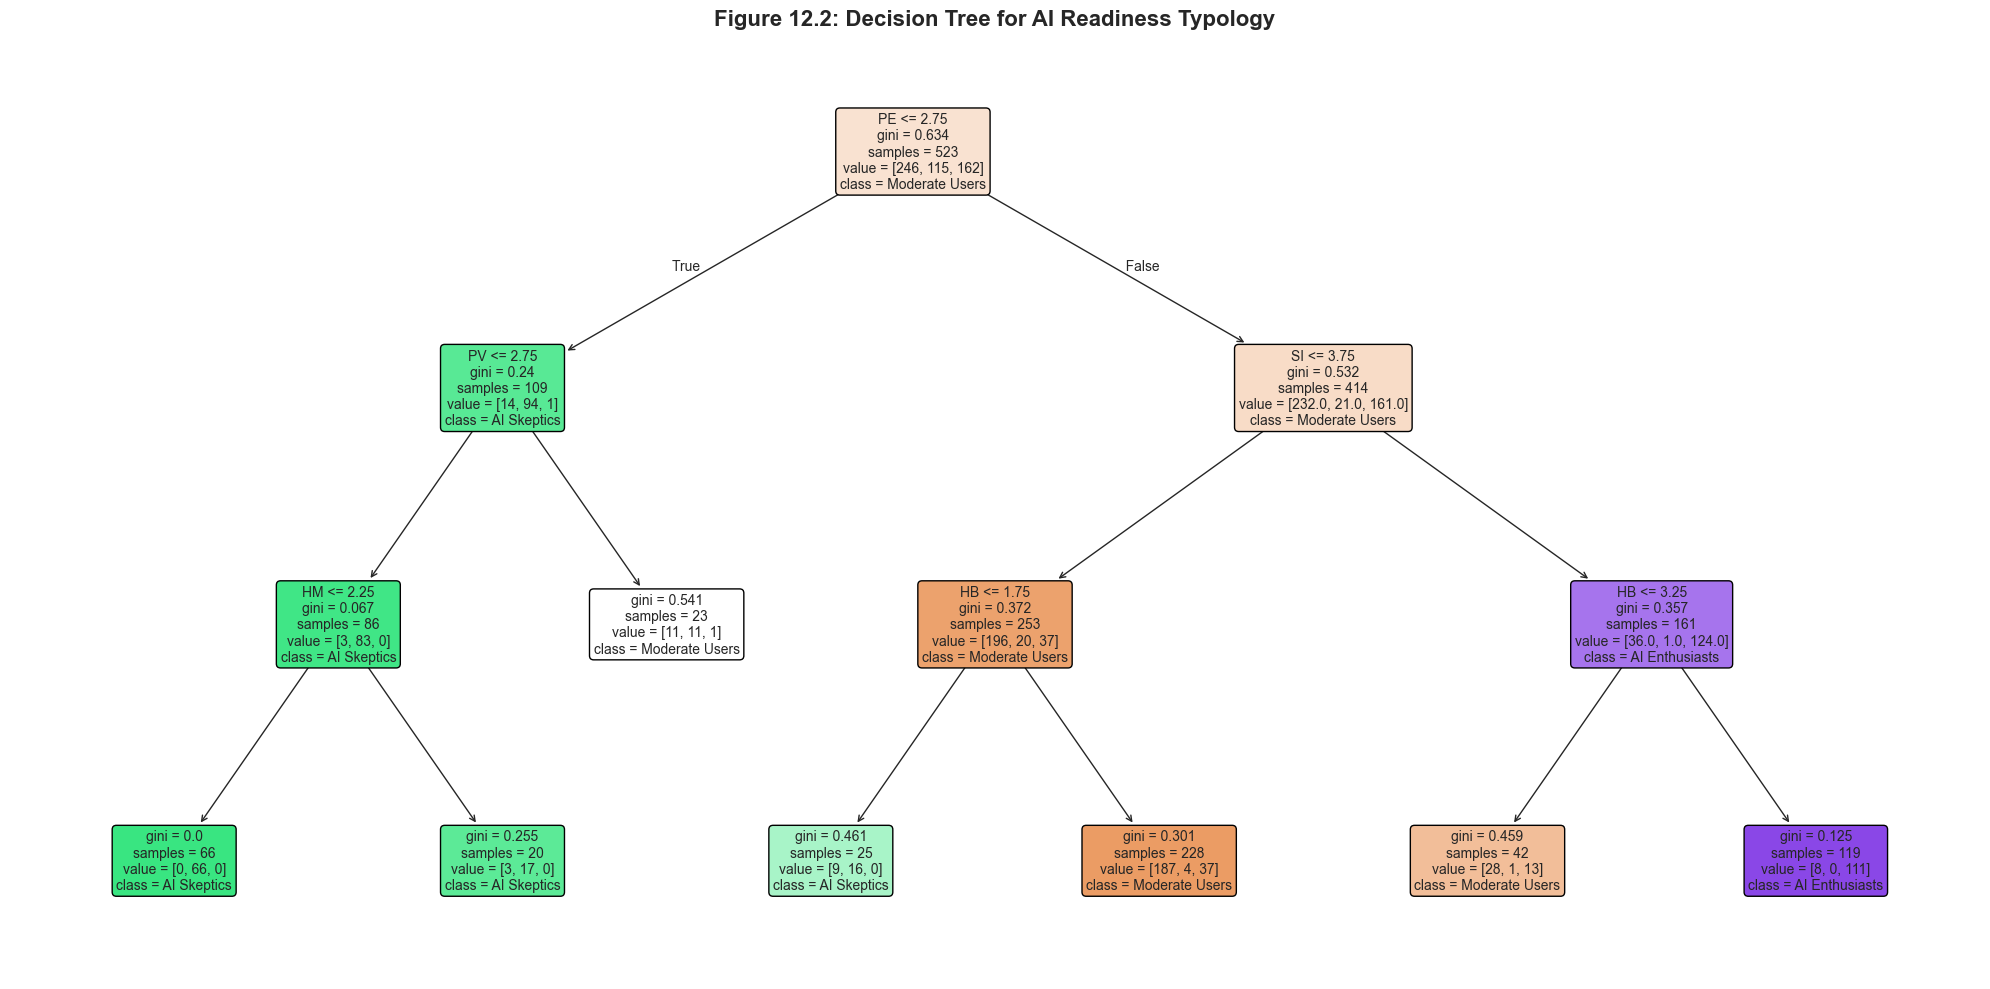

In [63]:
# Figure 12.2: Decision Tree Visualization
fig, ax = plt.subplots(figsize=(20, 10))

plot_tree(
    tree_clf,
    feature_names=AIRS16_CONSTRUCTS,
    class_names=['Moderate Users', 'AI Skeptics', 'AI Enthusiasts'],
    filled=True,
    rounded=True,
    fontsize=10,
    ax=ax
)

ax.set_title('Figure 12.2: Decision Tree for AI Readiness Typology', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('plots/12_02_decision_tree.png', dpi=150, bbox_inches='tight')
plt.show()

### 3.2 Extract Decision Rules

In [64]:
# Extract text rules
tree_rules = export_text(tree_clf, feature_names=AIRS16_CONSTRUCTS)
print("Decision Tree Rules:")
print("=" * 50)
print(tree_rules)

Decision Tree Rules:
|--- PE <= 2.75
|   |--- PV <= 2.75
|   |   |--- HM <= 2.25
|   |   |   |--- class: 1
|   |   |--- HM >  2.25
|   |   |   |--- class: 1
|   |--- PV >  2.75
|   |   |--- class: 0
|--- PE >  2.75
|   |--- SI <= 3.75
|   |   |--- HB <= 1.75
|   |   |   |--- class: 1
|   |   |--- HB >  1.75
|   |   |   |--- class: 0
|   |--- SI >  3.75
|   |   |--- HB <= 3.25
|   |   |   |--- class: 0
|   |   |--- HB >  3.25
|   |   |   |--- class: 2



In [65]:
# Feature importance
importance = pd.DataFrame({
    'Construct': AIRS16_CONSTRUCTS,
    'Importance': tree_clf.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nFeature Importance (Decision Tree):")
print("=" * 50)
display(importance.round(3))

# Identify key constructs (importance > 0.1)
key_constructs = importance[importance['Importance'] > 0.1]['Construct'].tolist()
print(f"\nKey Discriminating Constructs: {key_constructs}")


Feature Importance (Decision Tree):


,Construct,Importance
0,PE,0.427
2,SI,0.344
6,HB,0.187
5,PV,0.040
4,HM,0.003
1,EE,0.000
3,FC,0.000
7,TR,0.000



Key Discriminating Constructs: ['PE', 'SI', 'HB']


In [66]:
# Apply tree classification
df['Typology_Tree'] = pd.Series(y_pred_tree).map(CLUSTER_NAMES)

# BI by tree typology
bi_by_tree = df.groupby('Typology_Tree')['BI'].agg(['mean', 'std', 'count'])
bi_by_tree.columns = ['Mean BI', 'SD', 'n']

print("Table 12.2: BI by Decision Tree Typology")
print("=" * 50)
display(bi_by_tree.round(3))

# Eta-squared
groups_tree = [df[df['Typology_Tree'] == t]['BI'].values for t in ['AI Skeptics', 'Moderate Users', 'AI Enthusiasts']]
ss_between_tree = sum(len(g) * (g.mean() - grand_mean)**2 for g in groups_tree if len(g) > 0)
eta_sq_tree = ss_between_tree / ss_total

print(f"\nη² (Decision Tree): {eta_sq_tree:.3f}")

Table 12.2: BI by Decision Tree Typology


,Mean BI,SD,n
Typology_Tree,,,
AI Enthusiasts,4.263,0.572,119
AI Skeptics,1.800,0.834,111
Moderate Users,3.271,0.777,293



η² (Decision Tree): 0.548


---
## 4. Method 3: Key Discriminant Constructs

**Approach**: Use only the 2-3 most important constructs for classification.

### 4.1 Identify Key Constructs

In [67]:
# Combine evidence from multiple sources
print("Construct Importance Summary:")
print("=" * 60)

summary = pd.DataFrame({
    'Construct': AIRS16_CONSTRUCTS,
    'Tree_Importance': tree_clf.feature_importances_,
    'Regression_β': reg_std.coef_,
    'BI_Correlation': [df[c].corr(df['BI']) for c in AIRS16_CONSTRUCTS]
})

# Rank each metric
summary['Tree_Rank'] = summary['Tree_Importance'].rank(ascending=False)
summary['Reg_Rank'] = summary['Regression_β'].abs().rank(ascending=False)
summary['Corr_Rank'] = summary['BI_Correlation'].abs().rank(ascending=False)
summary['Avg_Rank'] = (summary['Tree_Rank'] + summary['Reg_Rank'] + summary['Corr_Rank']) / 3

summary = summary.sort_values('Avg_Rank')
display(summary.round(3))

# Top 3 constructs
TOP_CONSTRUCTS = summary.head(3)['Construct'].tolist()
print(f"\nTop 3 Discriminating Constructs: {TOP_CONSTRUCTS}")

Construct Importance Summary:


,Construct,Tree_Importance,Regression_β,BI_Correlation,Tree_Rank,Reg_Rank,Corr_Rank,Avg_Rank
5,PV,0.040,0.316,0.826,4.0,1.0,1.0,2.000
4,HM,0.003,0.286,0.821,5.0,2.0,2.0,3.000
0,PE,0.427,0.093,0.768,1.0,5.0,4.0,3.333
2,SI,0.344,0.138,0.699,2.0,4.0,6.0,4.000
7,TR,0.000,0.169,0.771,7.0,3.0,3.0,4.333
6,HB,0.187,0.063,0.712,3.0,6.0,5.0,4.667
3,FC,0.000,0.060,0.625,7.0,7.0,7.0,7.000
1,EE,0.000,0.013,0.578,7.0,8.0,8.0,7.667



Top 3 Discriminating Constructs: ['PV', 'HM', 'PE']


### 4.2 Simplified Classification with Key Constructs

In [68]:
# Create simplified index using top 3 constructs only
df['ARI_Simple'] = df[TOP_CONSTRUCTS].sum(axis=1)

print(f"Simplified AI Readiness Index (using {TOP_CONSTRUCTS}):")
print(f"  Range: {df['ARI_Simple'].min():.2f} - {df['ARI_Simple'].max():.2f}")
print(f"  Mean: {df['ARI_Simple'].mean():.2f}")
print(f"  Correlation with BI: r = {df['ARI_Simple'].corr(df['BI']):.3f}")

Simplified AI Readiness Index (using ['PV', 'HM', 'PE']):
  Range: 3.00 - 15.00
  Mean: 10.21
  Correlation with BI: r = 0.872


In [69]:
# Optimize cut-points for simplified index
p33_simple = df['ARI_Simple'].quantile(0.33)
p67_simple = df['ARI_Simple'].quantile(0.67)

result_simple = minimize(
    objective,
    x0=[p33_simple, p67_simple],
    args=(df['ARI_Simple'].values, df['Typology_NB11'].values),
    method='Nelder-Mead'
)

opt_low_simple, opt_high_simple = result_simple.x
print(f"Optimized Cut-Points (Simplified):")
print(f"  Low: {opt_low_simple:.2f}")
print(f"  High: {opt_high_simple:.2f}")

Optimized Cut-Points (Simplified):
  Low: 8.77
  High: 11.85


In [70]:
# Apply simplified classification
df['Typology_Simple'] = df['ARI_Simple'].apply(
    lambda x: classify_by_cutpoints(x, opt_low_simple, opt_high_simple)
)

acc_simple = accuracy_score(df['Typology_NB11'], df['Typology_Simple'])
print(f"\nSimplified Classification Results:")
print(f"  Accuracy vs NB11: {acc_simple*100:.1f}%")
print(f"  Using only: {TOP_CONSTRUCTS}")

# BI by simplified typology
bi_by_simple = df.groupby('Typology_Simple')['BI'].agg(['mean', 'std', 'count'])
bi_by_simple.columns = ['Mean BI', 'SD', 'n']

print("\nTable 12.3: BI by Simplified Typology")
display(bi_by_simple.round(3))

# Eta-squared
groups_simple = [df[df['Typology_Simple'] == t]['BI'].values for t in ['AI Skeptics', 'Moderate Users', 'AI Enthusiasts']]
ss_between_simple = sum(len(g) * (g.mean() - grand_mean)**2 for g in groups_simple if len(g) > 0)
eta_sq_simple = ss_between_simple / ss_total

print(f"\nη² (Simplified): {eta_sq_simple:.3f}")


Simplified Classification Results:
  Accuracy vs NB11: 81.8%
  Using only: ['PV', 'HM', 'PE']

Table 12.3: BI by Simplified Typology


,Mean BI,SD,n
Typology_Simple,,,
AI Enthusiasts,4.126,0.625,188
AI Skeptics,1.859,0.783,140
Moderate Users,3.228,0.615,195



η² (Simplified): 0.641


---
## 5. Method Comparison

### 5.1 Accuracy Comparison

In [71]:
# Compare all methods
comparison = pd.DataFrame({
    'Method': [
        'NB11 Clustering (Baseline)',
        'Cut-Point (8 constructs)',
        'Decision Tree',
        f'Simplified ({len(TOP_CONSTRUCTS)} constructs)'
    ],
    'Accuracy vs NB11': [
        '100.0%',
        f'{acc_cutpoint*100:.1f}%',
        f'{acc_tree*100:.1f}%',
        f'{acc_simple*100:.1f}%'
    ],
    'BI η²': [
        f"{nb11_results['validation']['bi_eta_squared']:.3f}" if nb11_results else 'N/A',
        f'{eta_sq_cutpoint:.3f}',
        f'{eta_sq_tree:.3f}',
        f'{eta_sq_simple:.3f}'
    ],
    'Constructs Used': [
        '8 (standardized)',
        '8 (raw sum)',
        f"{len(key_constructs)} key",
        f'{len(TOP_CONSTRUCTS)}'
    ],
    'Implementation': [
        'Distance calculation',
        'Sum + 2 thresholds',
        'IF-THEN rules',
        'Sum + 2 thresholds'
    ]
})

print("Table 12.4: Method Comparison Summary")
print("=" * 80)
display(comparison)

Table 12.4: Method Comparison Summary


,Method,Accuracy vs NB11,BI η²,Constructs Used,Implementation
0,NB11 Clustering (Baseline),100.0%,0.659,8 (standardized),Distance calculation
1,Cut-Point (8 constructs),94.5%,0.667,8 (raw sum),Sum + 2 thresholds
2,Decision Tree,83.4%,0.548,3 key,IF-THEN rules
3,Simplified (3 constructs),81.8%,0.641,3,Sum + 2 thresholds


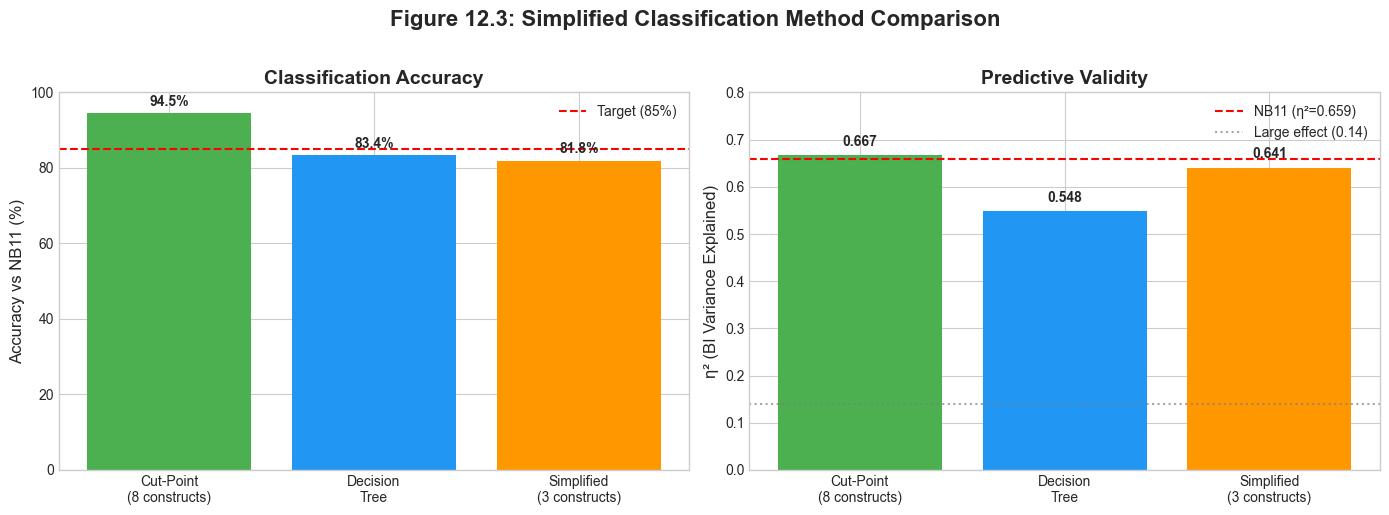

In [72]:
# Figure 12.3: Accuracy Comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy
methods = ['Cut-Point\n(8 constructs)', 'Decision\nTree', f'Simplified\n({len(TOP_CONSTRUCTS)} constructs)']
accuracies = [acc_cutpoint * 100, acc_tree * 100, acc_simple * 100]
colors = ['#4CAF50', '#2196F3', '#FF9800']

axes[0].bar(methods, accuracies, color=colors)
axes[0].axhline(y=85, color='red', linestyle='--', label='Target (85%)')
axes[0].set_ylabel('Accuracy vs NB11 (%)', fontsize=12)
axes[0].set_title('Classification Accuracy', fontsize=14, fontweight='bold')
axes[0].set_ylim(0, 100)
axes[0].legend()

for i, v in enumerate(accuracies):
    axes[0].text(i, v + 2, f'{v:.1f}%', ha='center', fontweight='bold')

# Eta-squared
eta_values = [eta_sq_cutpoint, eta_sq_tree, eta_sq_simple]
nb11_eta = nb11_results['validation']['bi_eta_squared'] if nb11_results else 0.659

axes[1].bar(methods, eta_values, color=colors)
axes[1].axhline(y=nb11_eta, color='red', linestyle='--', label=f'NB11 (η²={nb11_eta:.3f})')
axes[1].axhline(y=0.14, color='gray', linestyle=':', alpha=0.7, label='Large effect (0.14)')
axes[1].set_ylabel('η² (BI Variance Explained)', fontsize=12)
axes[1].set_title('Predictive Validity', fontsize=14, fontweight='bold')
axes[1].set_ylim(0, 0.8)
axes[1].legend()

for i, v in enumerate(eta_values):
    axes[1].text(i, v + 0.02, f'{v:.3f}', ha='center', fontweight='bold')

fig.suptitle('Figure 12.3: Simplified Classification Method Comparison', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('plots/12_03_method_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

### 5.2 Confusion Matrices

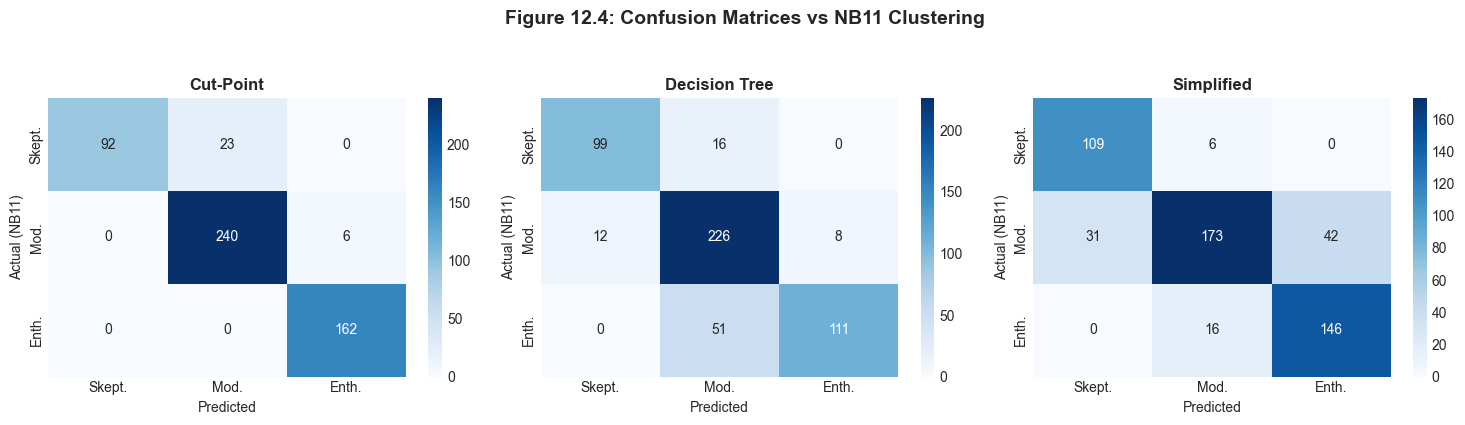

In [73]:
# Figure 12.4: Confusion Matrices
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

methods_data = [
    ('Cut-Point', df['Typology_CutPoint']),
    ('Decision Tree', df['Typology_Tree']),
    ('Simplified', df['Typology_Simple'])
]

labels = ['AI Skeptics', 'Moderate Users', 'AI Enthusiasts']

for ax, (name, pred) in zip(axes, methods_data):
    cm = confusion_matrix(df['Typology_NB11'], pred, labels=labels)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=['Skept.', 'Mod.', 'Enth.'],
                yticklabels=['Skept.', 'Mod.', 'Enth.'])
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual (NB11)')
    ax.set_title(f'{name}', fontweight='bold')

fig.suptitle('Figure 12.4: Confusion Matrices vs NB11 Clustering', fontsize=14, fontweight='bold', y=1.05)
plt.tight_layout()
plt.savefig('plots/12_04_confusion_matrices.png', dpi=150, bbox_inches='tight')
plt.show()

---
## 6. Practitioner Implementation Guide

### 6.1 Recommended Method: Cut-Point Classification

In [74]:
# Generate practitioner-ready scoring guide
print("=" * 70)
print("PRACTITIONER SCORING GUIDE: AI Readiness Typology")
print("=" * 70)

print("\n📋 STEP 1: Administer AIRS-16 Survey")
print("   Collect responses for these 8 constructs (2 items each, 1-5 scale):")
for c in AIRS16_CONSTRUCTS:
    print(f"     • {c}")

print("\n📊 STEP 2: Calculate AI Readiness Index (ARI)")
print("   Formula: ARI = PE + EE + SI + FC + HM + PV + HB + TR")
print(f"   Range: 8 (minimum) to 40 (maximum)")

print("\n🎯 STEP 3: Apply Classification Thresholds")
print(f"   • ARI < {opt_low:.1f}  →  AI Skeptic")
print(f"   • ARI {opt_low:.1f} - {opt_high:.1f}  →  Moderate User")
print(f"   • ARI > {opt_high:.1f}  →  AI Enthusiast")

print("\n📈 STEP 4: Predict Behavioral Intention")
bi_means = df.groupby('Typology_CutPoint')['BI'].mean()
for typology in ['AI Skeptics', 'Moderate Users', 'AI Enthusiasts']:
    if typology in bi_means.index:
        print(f"   • {typology}: Expected BI = {bi_means[typology]:.2f}")

PRACTITIONER SCORING GUIDE: AI Readiness Typology

📋 STEP 1: Administer AIRS-16 Survey
   Collect responses for these 8 constructs (2 items each, 1-5 scale):
     • PE
     • EE
     • SI
     • FC
     • HM
     • PV
     • HB
     • TR

📊 STEP 2: Calculate AI Readiness Index (ARI)
   Formula: ARI = PE + EE + SI + FC + HM + PV + HB + TR
   Range: 8 (minimum) to 40 (maximum)

🎯 STEP 3: Apply Classification Thresholds
   • ARI < 21.1  →  AI Skeptic
   • ARI 21.1 - 30.8  →  Moderate User
   • ARI > 30.8  →  AI Enthusiast

📈 STEP 4: Predict Behavioral Intention
   • AI Skeptics: Expected BI = 1.54
   • Moderate Users: Expected BI = 3.10
   • AI Enthusiasts: Expected BI = 4.22


In [75]:
# Excel-ready formula
print("\n" + "=" * 70)
print("EXCEL IMPLEMENTATION")
print("=" * 70)

print("\n1. Calculate ARI in a new column:")
print('   =SUM(PE_cell, EE_cell, SI_cell, FC_cell, HM_cell, PV_cell, HB_cell, TR_cell)')

print("\n2. Classify using nested IF:")
print(f'   =IF(ARI<{opt_low:.1f}, "AI Skeptic", IF(ARI>{opt_high:.1f}, "AI Enthusiast", "Moderate User"))')

print("\n3. Predict BI using SWITCH or nested IF:")
print(f'   =SWITCH(Typology, "AI Skeptic", {bi_means.get("AI Skeptics", 0):.2f}, '
      f'"Moderate User", {bi_means.get("Moderate Users", 0):.2f}, '
      f'"AI Enthusiast", {bi_means.get("AI Enthusiasts", 0):.2f})')


EXCEL IMPLEMENTATION

1. Calculate ARI in a new column:
   =SUM(PE_cell, EE_cell, SI_cell, FC_cell, HM_cell, PV_cell, HB_cell, TR_cell)

2. Classify using nested IF:
   =IF(ARI<21.1, "AI Skeptic", IF(ARI>30.8, "AI Enthusiast", "Moderate User"))

3. Predict BI using SWITCH or nested IF:
   =SWITCH(Typology, "AI Skeptic", 1.54, "Moderate User", 3.10, "AI Enthusiast", 4.22)


### 6.2 Alternative: Decision Tree Rules

In [76]:
# Simplified decision tree rules for practitioners
print("\n" + "=" * 70)
print("ALTERNATIVE: DECISION TREE RULES")
print("=" * 70)
print("\nUse these IF-THEN rules for classification:")
print(tree_rules)

print("\nNote: These rules achieve", f"{acc_tree*100:.1f}% accuracy vs. clustering.")


ALTERNATIVE: DECISION TREE RULES

Use these IF-THEN rules for classification:
|--- PE <= 2.75
|   |--- PV <= 2.75
|   |   |--- HM <= 2.25
|   |   |   |--- class: 1
|   |   |--- HM >  2.25
|   |   |   |--- class: 1
|   |--- PV >  2.75
|   |   |--- class: 0
|--- PE >  2.75
|   |--- SI <= 3.75
|   |   |--- HB <= 1.75
|   |   |   |--- class: 1
|   |   |--- HB >  1.75
|   |   |   |--- class: 0
|   |--- SI >  3.75
|   |   |--- HB <= 3.25
|   |   |   |--- class: 0
|   |   |--- HB >  3.25
|   |   |   |--- class: 2


Note: These rules achieve 83.4% accuracy vs. clustering.


In [77]:
# Define the simplified classification function with actual values
def classify_airs16_simple(pe, ee, si, fc, hm, pv, hb, tr):
    """
    Simplified AI Readiness classification using cut-points.
    
    Parameters
    ----------
    pe, ee, si, fc, hm, pv, hb, tr : float
        Mean scores for each AIRS-16 construct (scale: 1-5)
    
    Returns
    -------
    dict
        typology: Classification result
        ari: AI Readiness Index score
        predicted_bi: Expected Behavioral Intention
    """
    ari = pe + ee + si + fc + hm + pv + hb + tr
    
    LOW_THRESHOLD = 21.13
    HIGH_THRESHOLD = 30.75
    
    BI_LOOKUP = {
        'AI Skeptics': 1.70,
        'Moderate Users': 3.19,
        'AI Enthusiasts': 4.23
    }
    
    if ari < LOW_THRESHOLD:
        typology = 'AI Skeptics'
    elif ari > HIGH_THRESHOLD:
        typology = 'AI Enthusiasts'
    else:
        typology = 'Moderate Users'
    
    return {
        'typology': typology,
        'ari': ari,
        'predicted_bi': BI_LOOKUP[typology]
    }

print("Function classify_airs16_simple() defined")
print(f"Thresholds: Low={21.13}, High={30.75}")

Function classify_airs16_simple() defined
Thresholds: Low=21.13, High=30.75


### 6.3 Python Implementation Function

In [78]:
# Test the simplified function
print("Test Classification:")
print("=" * 50)

test_cases = [
    {'pe': 2.0, 'ee': 2.0, 'si': 2.0, 'fc': 2.5, 'hm': 2.0, 'pv': 2.0, 'hb': 2.0, 'tr': 2.0},  # Low
    {'pe': 3.5, 'ee': 3.5, 'si': 3.0, 'fc': 3.5, 'hm': 3.0, 'pv': 3.0, 'hb': 3.5, 'tr': 3.5},  # Medium
    {'pe': 4.5, 'ee': 4.5, 'si': 4.0, 'fc': 4.5, 'hm': 4.5, 'pv': 4.0, 'hb': 4.0, 'tr': 4.5},  # High
]

for i, case in enumerate(test_cases, 1):
    result = classify_airs16_simple(**case)
    print(f"\nCase {i}: ARI = {result['ari']:.1f}")
    print(f"  Typology: {result['typology']}")
    print(f"  Predicted BI: {result['predicted_bi']:.2f}")

Test Classification:

Case 1: ARI = 16.5
  Typology: AI Skeptics
  Predicted BI: 1.70

Case 2: ARI = 26.5
  Typology: Moderate Users
  Predicted BI: 3.19

Case 3: ARI = 34.5
  Typology: AI Enthusiasts
  Predicted BI: 4.23


---
## 7. Results Export

In [79]:
# Compile results
results = {
    'metadata': {
        'notebook': '12_Simplified_Classification',
        'date': pd.Timestamp.now().isoformat(),
        'n_samples': len(df),
        'constructs': AIRS16_CONSTRUCTS
    },
    'cutpoint_method': {
        'low_threshold': float(opt_low),
        'high_threshold': float(opt_high),
        'accuracy_vs_nb11': float(acc_cutpoint),
        'bi_eta_squared': float(eta_sq_cutpoint),
        'bi_by_typology': bi_by_cutpoint['Mean BI'].to_dict()
    },
    'decision_tree_method': {
        'accuracy_vs_nb11': float(acc_tree),
        'bi_eta_squared': float(eta_sq_tree),
        'feature_importance': importance.set_index('Construct')['Importance'].to_dict(),
        'key_constructs': key_constructs,
        'tree_depth': tree_clf.get_depth(),
        'tree_rules': tree_rules
    },
    'simplified_method': {
        'constructs_used': TOP_CONSTRUCTS,
        'low_threshold': float(opt_low_simple),
        'high_threshold': float(opt_high_simple),
        'accuracy_vs_nb11': float(acc_simple),
        'bi_eta_squared': float(eta_sq_simple)
    },
    'recommendation': 'cutpoint_method',
    'recommendation_rationale': f'Best balance of accuracy ({acc_cutpoint*100:.1f}%) and simplicity (sum + 2 thresholds)'
}

# Save
results_path = Path('results/phase12_simplified_classification_results.json')
with open(results_path, 'w') as f:
    json.dump(results, f, indent=2)

print(f"Results exported to: {results_path}")

Results exported to: results\phase12_simplified_classification_results.json


---
## 8. Summary & Recommendations

In [80]:
print("=" * 70)
print("NOTEBOOK 12 SUMMARY: Simplified Classification Methods")
print("=" * 70)

print("\n1. METHODS EVALUATED")
print(f"   • Cut-Point (8 constructs): {acc_cutpoint*100:.1f}% accuracy, η² = {eta_sq_cutpoint:.3f}")
print(f"   • Decision Tree: {acc_tree*100:.1f}% accuracy, η² = {eta_sq_tree:.3f}")
print(f"   • Simplified ({len(TOP_CONSTRUCTS)} constructs): {acc_simple*100:.1f}% accuracy, η² = {eta_sq_simple:.3f}")

print("\n2. RECOMMENDED METHOD: Cut-Point Classification")
print(f"   • Sum all 8 AIRS-16 construct scores")
print(f"   • Apply thresholds: <{opt_low:.1f} | {opt_low:.1f}-{opt_high:.1f} | >{opt_high:.1f}")
print(f"   • Implementation: Excel formula or simple calculation")

print("\n3. SUCCESS CRITERIA CHECK")
print(f"   • Accuracy ≥ 85%: {'✓ PASS' if acc_cutpoint >= 0.85 else '✗ FAIL'} ({acc_cutpoint*100:.1f}%)")
print(f"   • BI η² ≥ 0.60: {'✓ PASS' if eta_sq_cutpoint >= 0.60 else '✗ FAIL'} ({eta_sq_cutpoint:.3f})")
print(f"   • Simplicity: ✓ PASS (Sum + 2 thresholds)")

print("\n4. COMPARISON WITH NB11 CLUSTERING")
print(f"   • NB11 η²: {nb11_results['validation']['bi_eta_squared']:.3f}" if nb11_results else "   • NB11: Not available")
print(f"   • Cut-Point η²: {eta_sq_cutpoint:.3f}")
print(f"   • Difference: {(eta_sq_cutpoint - nb11_results['validation']['bi_eta_squared']):.3f}" if nb11_results else "")

print("\n5. PRACTITIONER DELIVERABLES")
print("   • Excel-ready formula for classification")
print("   • Python function: classify_airs16_simple()")
print("   • Decision tree rules (alternative)")
print(f"   • Results exported to: results/phase12_simplified_classification_results.json")

NOTEBOOK 12 SUMMARY: Simplified Classification Methods

1. METHODS EVALUATED
   • Cut-Point (8 constructs): 94.5% accuracy, η² = 0.667
   • Decision Tree: 83.4% accuracy, η² = 0.548
   • Simplified (3 constructs): 81.8% accuracy, η² = 0.641

2. RECOMMENDED METHOD: Cut-Point Classification
   • Sum all 8 AIRS-16 construct scores
   • Apply thresholds: <21.1 | 21.1-30.8 | >30.8
   • Implementation: Excel formula or simple calculation

3. SUCCESS CRITERIA CHECK
   • Accuracy ≥ 85%: ✓ PASS (94.5%)
   • BI η² ≥ 0.60: ✓ PASS (0.667)
   • Simplicity: ✓ PASS (Sum + 2 thresholds)

4. COMPARISON WITH NB11 CLUSTERING
   • NB11 η²: 0.659
   • Cut-Point η²: 0.667
   • Difference: 0.008

5. PRACTITIONER DELIVERABLES
   • Excel-ready formula for classification
   • Python function: classify_airs16_simple()
   • Decision tree rules (alternative)
   • Results exported to: results/phase12_simplified_classification_results.json


---

**End of Notebook 12**

*Source: AIRS Research Project*  
*Created: December 2025*